In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import Can_Algorithms as alg
import numpy as nmp
import logging as log
import datetime
import os
import umap
import seaborn as sns  # for visualizing the confusion matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from scipy.interpolate import interp1d
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from appconfig import Config
from sklearn.feature_selection import RFE
import itertools
from tabulate import tabulate

In [6]:
# Initialize Config with the environment ('dev' or 'prod') and get Configuration value
appconfig = Config('dev')
log_folder=appconfig.getconfig_from_key("log_folder")
log_filename=appconfig.getconfig_from_key("log_filename")
datasets=appconfig.getconfig_from_key("datasets")
train_models=appconfig.getconfig_from_key("train_models")

# Configure logging to save log file in the folder
os.makedirs(log_folder, exist_ok=True)
log_file = os.path.join(log_folder, log_filename)
log.basicConfig(filename=log_file,
                level=log.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [7]:
def label_encode(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                label_encoder = LabelEncoder()
                df[col] = label_encoder.fit_transform(df[col])

#Function to convert hex string to integer
def hex_to_int(x):
    if isinstance(x, str):
        try:
            return int(x, 16)
        except ValueError:
            return nmp.nan
    else:
        return x

def getDate():
    current_ts = datetime.datetime.now()
    formatted_time= current_ts.strftime("%Y-%m-%d %H:%M:%S")
    return current_ts,formatted_time

def PreprocessData(data, testSize=0.2): 
    ds =data    # Assign column names
    
    print("---Dataset Info---")
    print(ds.info())
    print("---Dataset Objects---")
    print(ds.describe(include='object'))
    print("---Dataset Shape---")
    # print(ds.shape())
    print(ds.isnull().sum())    

    total = ds.shape[0]
    missing_columns = [col for col in ds.columns if ds[col].isnull().sum() > 0]
    for col in missing_columns:
        null_count = ds[col].isnull().sum()
        per = (null_count/total) * 100
        print(f"{col}: {null_count} ({round(per, 3)}%)")

    print(f"Number of duplicate rows: {ds.duplicated().sum()}")

    #Plot the type of Attacks
    sns.countplot(x=ds['Label'])

    print('Class distribution Training set:')
    print(ds['Label'].value_counts())

    #Label encode of dataset
    label_encode(ds)  

    
    ds.drop(['Timestamp'], axis=1, inplace=True)
    # ds.head()
    X=ds.drop(['Label'],axis=1)
    y=ds['Label']


    rfc = RandomForestClassifier()

    rfe = RFE(rfc, n_features_to_select=5)
    rfe = rfe.fit(X, y)

    feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X.columns)]
    selected_features = [v for i, v in feature_map if i==True]
    # selected_features=['CAN_ID', 'DATA0', 'DATA1', 'DATA2', 'DATA3']

    print("-----------Selected features----------")
    print(selected_features)

    X = X[selected_features] #Set the best features for training
  
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state=42)
    # return x_train, x_test, y_train, y_test
    scale = StandardScaler()
    X_train = scale.fit_transform(X)
    print("X Train")
    print(X_train)

     # Impute missing values using SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(x_train)
   
    X_test_imputed = imputer.transform(x_test)
    return X_train_imputed,X_test_imputed,y_train,y_test
       

def PlotBarGraph(models,metrics,values,title,x_label,y_label):
    # Plotting
    plt.figure(figsize=(5,3))

    # Plot bars for each metric and model
    bar_width = 0.2
    index = nmp.arange(len(models))

    for i, metric in enumerate(metrics):
        plt.bar(index + i * bar_width, values[i], bar_width, label=metric)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(index + bar_width * 1.5, models)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

def PlotLineGraph(models,metrics,values,title,x_label,y_label):
    # Plot curved lines for each metric and model
    for i, metric in enumerate(metrics):
        f = interp1d(nmp.arange(len(models)), values[i], kind='cubic')
        x_new = nmp.linspace(0, len(models) - 1, 100)
        y_new = f(x_new)
        plt.plot(x_new, y_new, label=metric)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(nmp.arange(len(models)), models)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix with specified labels for normal and attack traffic.
    """
    if not title:
        title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)  # Ensure labels are in the correct order: [Normal, Attack]
    # classes = ['Normal', 'Dos','Fuzzy','RPM','Gear']

    # Print confusion matrix values
    print('Confusion matrix, without normalization')
    print(cm)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)
    ax.xaxis.set_ticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])  # Adjust as necessary
    ax.yaxis.set_ticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
    plt.show()


         Timestamp CAN_ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6  \
0     1.479121e+09   02c0    8    14    00    00    00    00    00    00   
1     1.479121e+09   0430    8    00    00    00    00    00    00    00   
2     1.479121e+09   04b1    8    00    00    00    00    00    00    00   
3     1.479121e+09   01f1    8    00    00    00    00    00    00    00   
4     1.479121e+09   0153    8    00    00    00    ff    00    ff    00   
...            ...    ...  ...   ...   ...   ...   ...   ...   ...   ...   
4995  1.479121e+09   02c0    8    14    00    00    00    00    00    00   
4996  1.479121e+09   0350    8    05    28    84    66    6d    00    00   
4997  1.479121e+09   0316    8    05    25    94    09    25    23    00   
4998  1.479121e+09   018f    8    fe    36    00    00    00    3c    00   
4999  1.478198e+09   018f    8    fe    5b    00    00    00    3c    00   

     DATA7 Flag  Label  
0       00    R      0  
1       00    R      0  
2       00  

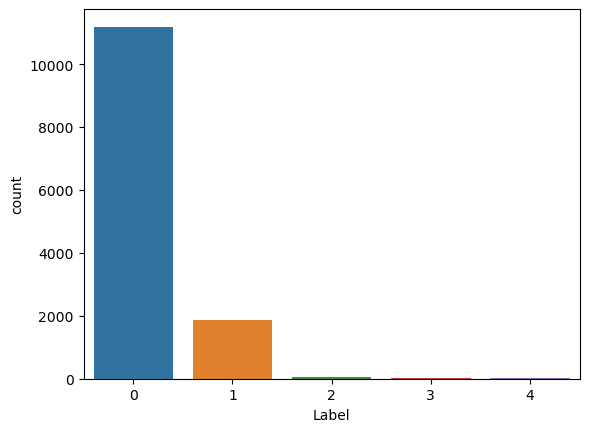

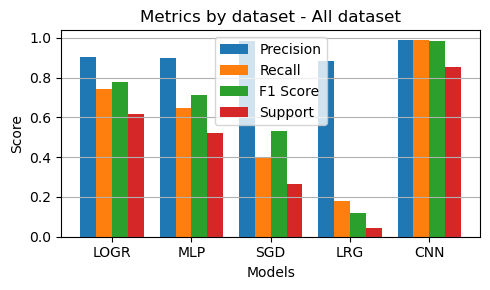

In [8]:

log.info("#####################################")
log.info("Running dataset: [All]")
log.info("#####################################")
precision = []
recall = []
f1_score = []
support = []
results =[]
data=[]
metrics=[]
values=[]
normal_df = pd.read_csv(appconfig.getconfig_from_keys(["data_path","normal"]) )
normal_df.columns = appconfig.getconfig_from_key("dataset_columns")
dos_df = pd.read_csv(appconfig.getconfig_from_keys(["data_path","dos"]) )
dos_df.columns = appconfig.getconfig_from_key("dataset_columns")

fuzzy_df = pd.read_csv(appconfig.getconfig_from_keys(["data_path","fuzzy"]) )
fuzzy_df.columns = appconfig.getconfig_from_key("dataset_columns")

rpm_df = pd.read_csv(appconfig.getconfig_from_keys(["data_path","rpm"]) )
rpm_df.columns = appconfig.getconfig_from_key("dataset_columns")

gear_df = pd.read_csv(appconfig.getconfig_from_keys(["data_path","gear"]) )
gear_df.columns = appconfig.getconfig_from_key("dataset_columns")



normal_df['Label'] = 0  # All entries are normal
dos_df['Label'] = dos_df['Flag'].apply(lambda x: 0 if x == 'R' else 1) # 0 means Normal 1 means Dos Attacks
fuzzy_df['Label'] = fuzzy_df['Flag'].apply(lambda x: 0 if x == 'R' else 2)# 0 means Normal 2 means Fuzzy Attacks
rpm_df['Label'] = rpm_df['Flag'].apply(lambda x: 0 if x == 'R' else 3)# 0 means Normal 1 means RPM Attacks
gear_df['Label'] = gear_df['Flag'].apply(lambda x: 0 if x == 'R' else 4)# 0 means Normal 1 means Gear Attacks

combined_df = pd.concat([normal_df, dos_df, fuzzy_df, rpm_df, gear_df], ignore_index=True)

print(combined_df.head(5000))
# dataPath=appconfig.getconfig_from_keys(["data_path","normal"])  
# print(f"Datapath: {dataPath}")
#Load Data
x_train, x_test, y_train, y_test = PreprocessData(combined_df,0.2)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
print(f"x train")
print(x_train)
total_samples = len(y_test)
print(f"Total Samples: {total_samples}")
# Run and evaluate each model
for model_name in train_models:
    print('-------------------------------')
    print('Model: ',model_name)
    print('-------------------------------')        
    if model_name == 'SVC':
        start_ts,formatted_start_ts = getDate()
        log.info("Starting SVC model...[%s]",formatted_start_ts)
        y_pred,training_score,testing_score = alg.SVC_Scan(x_train, y_train, x_test,y_test)
        end_ts,formatted_end_ts = getDate()
        data.append(["Support Vector Classifier", training_score, testing_score])
        log.info('SVC model finished. Elapsed time: %s',
        end_ts - start_ts)    
    elif model_name == 'LOGR':
        start_ts,formatted_start_ts = getDate()
        log.info("Starting Logistic Regression model...[%s]",formatted_start_ts)
        y_pred,training_score,testing_score = alg.Logistic_regression_Scan(x_train, y_train, x_test,y_test) 
        end_ts,formatted_end_ts = getDate()
        data.append(["Logistic Regression", training_score, testing_score])
        log.info('Logistic Regression model finished. Elapsed time: %s',
        end_ts - start_ts)
    elif model_name == 'MLP':
        start_ts,formatted_start_ts = getDate()
        log.info("Starting MLP model...[%s]",formatted_start_ts)
        y_pred,training_score,testing_score = alg.MLP_Scan(x_train, y_train, x_test,y_test)
        end_ts,formatted_end_ts = getDate()
        data.append(["MLP Classifier", training_score, testing_score])
        log.info('MLP model finished. Elapsed time: %s',
        end_ts - start_ts)
    elif model_name == 'SGD':
        start_ts,formatted_start_ts = getDate()
        log.info("Starting SGD model...[%s]",formatted_start_ts)
        y_pred,training_score,testing_score = alg.SGD_Scan(x_train, y_train, x_test,y_test)
        end_ts,formatted_end_ts = getDate()
        data.append(["SGD Classifier", training_score, testing_score])
        log.info('SGD model finished. Elapsed time: %s',
            end_ts - start_ts)
    elif model_name == 'LRG':
        start_ts,formatted_start_ts = getDate()
        log.info("Starting Linear regression model...[%s]",formatted_start_ts)
        y_pred,training_score,testing_score = alg.Linear_regression_Scan(x_train, y_train, x_test,y_test)          
        end_ts,formatted_end_ts = getDate()
        data.append(["Linear Regression", training_score, testing_score])
        log.info('Linear regression model finished. Elapsed time: %s',
        end_ts - start_ts)
    elif model_name == 'CNN':
        start_ts,formatted_start_ts = getDate()
        log.info("Starting CNN model...[%s]",formatted_start_ts)
        y_pred,training_score,testing_score = alg.CNN_Scan(x_train, y_train, x_test,y_test) 
        end_ts,formatted_end_ts = getDate()
        data.append(["CNN model", training_score, testing_score])
        log.info('CNN model finished. Elapsed time: %s',
        end_ts - start_ts)
    print(f"--Report for "+model_name+"--")
    print(classification_report(y_test, y_pred, zero_division=1))
    precision_score, recall_score, f1_score_val, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=1)
    precision.append(precision_score)
    recall.append(recall_score)
    f1_score.append(f1_score_val)
        # support.append(1)
    support_score=(pd.Series(y_pred).value_counts() / len(y_pred)).loc[0]
    support.append(support_score)
    # plot_confusion_matrix(y_test, y_pred, title=f'Confusion Matrix - {model_name}')
    # plot_attack_scatter(y_test,y_pred)
  
    print('Precision:',precision_score)
    print('Recall:',recall_score)
    print('f1 score:',f1_score_val)
    print('Support:',support_score)

col_names = ["Model", "Train Score", "Test Score"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))
    # Define the metrics to plot
metrics = ['Precision', 'Recall', 'F1 Score', 'Support']
values = [precision, recall, f1_score, support]
print(values) 
PlotBarGraph(train_models,metrics,values,'Metrics by dataset - All dataset','Models','Score')
        